# Architecture explanation

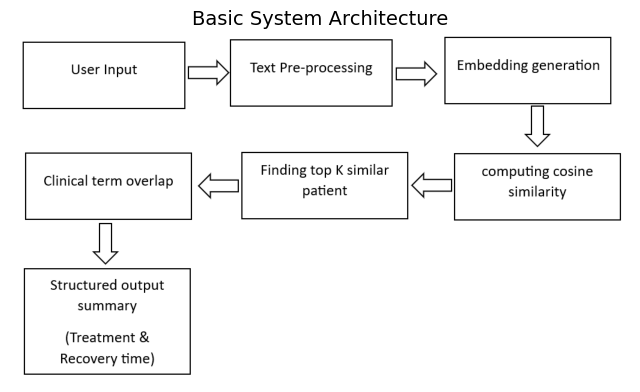

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load image
img = mpimg.imread(r"C:\Users\rajak\OneDrive\Pictures\Screenshots\Screenshot 2026-02-18 152905.png")

# Display image
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.title("Basic System Architecture", fontsize=14)
plt.axis("off")
plt.show()


Archtecture explanation

The user input block receives the new patient's clinical symptoms and doctor's notes in a string format. This user input serves as the query that will be compared against existing patient records.
Then the input text is cleaned by removing the noises, stop words, abbreviation handling, and performing the spell check.
The preprocessed text with the meaningful clinical terms is converted into a dense numerical vector in the embedding generation phase. The vector embedding of the user input is compared with the stored patient embeddings using the cosine similarity. This produces a similarity score that indicates how closely two clinical cases are related to each other. Then the similarity scores are sorted to identify the most relevant historical terms that share several common symptoms and medical terms. From the top similar patient, the treatment and the recovery period that were provided to the new patient has suggestion.

# Input and output schema

Input schema

In [1]:
# defining the input schema
if __name__ == "__main__":
    # Get user input
    print("Enter Patient Symptoms:")
    symptoms = input(">> ")
    print("\nEnter Clinical Notes:")
    clinical_notes = input(">> ")
    # Print provided input
    print("\n Provided Input")
    print("Symptoms:", symptoms)
    print("Clinical Notes:", clinical_notes)
    # Print data types
    print("\n Input Data Types")
    print("Symptoms Type:", type(symptoms).__name__)
    print("Clinical Notes Type:", type(clinical_notes).__name__)


Enter Patient Symptoms:


>>  fever, cold and difficulty in breathing



Enter Clinical Notes:


>>  The patient developed worsening shortness of breath with persistent cough and fever, accompanied by hypoxia and oxygen desaturation requiring close respiratory monitoring.



 Provided Input
Symptoms: fever, cold and difficulty in breathing
Clinical Notes: The patient developed worsening shortness of breath with persistent cough and fever, accompanied by hypoxia and oxygen desaturation requiring close respiratory monitoring.

 Input Data Types
Symptoms Type: str
Clinical Notes Type: str


From this we can be able to see that the user inputs provided are the symptoms and the clinical notes by the clinicians. The type of the provided inputs are strings.

The inputs obtained from the users are symptoms they have and the clinical notes provided by the clinicians

Output schema

In [4]:
# defining the proper output schema
import os
import re
import warnings
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")
# major treatment
TREATMENT_KEYWORDS = [
    "aspirin", "insulin", "metformin", "antibiotics",
    "surgery", "chemotherapy", "radiation",
    "antihypertensive", "beta blocker", "steroids",
    "antiepileptic", "oxygen therapy", "physiotherapy",
    "analgesic", "paracetamol", "ibuprofen",
    "antiviral", "antifungal", "anticoagulant",
    "dialysis", "ventilation", "rehabilitation",
    "hydration", "rest", "inhaler", "bronchodilator",
    "cardiac monitoring", "lifestyle modification"
]
# pre-processing
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    words = text.split()
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]

    return " ".join(words)
# extracting the treatments
def extract_treatments(note):
    found = []
    for keyword in TREATMENT_KEYWORDS:
        if keyword in note:
            found.append(keyword)
    return list(set(found))
# extracting the recovery period
def extract_recovery_period(note):
    pattern = r'(\d+\s?(day|days|week|weeks|month|months))'
    matches = re.findall(pattern, note)

    recovery = []
    for match in matches:
        recovery.append(match[0])

    return list(set(recovery))
# loading the data
def load_dataset(path, limit=600):
    df = pd.read_csv(path)
    df = df.iloc[:limit].copy().reset_index(drop=True)

    df["patient_uid"] = [f"P{i:05d}" for i in range(len(df))]
    df["note_processed"] = df["note_preprocessed"].apply(preprocess_text)

    return df

# building the embeddings
def build_embeddings(model, df):
    texts = df["note_processed"].tolist()
    embeddings = model.encode(
        texts,
        convert_to_numpy=True,
        show_progress_bar=False
    )
    return embeddings
# similarity score
def retrieve_similar_cases(user_symptoms,
                           user_notes,
                           model,
                           df,
                           embeddings,
                           top_k=3):

    combined_input = user_symptoms + " " + user_notes
    processed_input = preprocess_text(combined_input)

    user_embedding = model.encode([processed_input], convert_to_numpy=True)
    similarities = cosine_similarity(user_embedding, embeddings)[0]
    top_indices = similarities.argsort()[-top_k:][::-1]

    similar_case_ids = []
    similarity_scores = []
    treatments = []
    recovery_periods = []
    shared_terms = []

    for idx in top_indices:
        similar_case_ids.append(df.iloc[idx]["patient_uid"])
        similarity_scores.append(round(float(similarities[idx]), 4))

        matched_note = df.iloc[idx]["note_processed"]

        treatments.extend(extract_treatments(matched_note))
        recovery_periods.extend(extract_recovery_period(matched_note))

        # Extract common words (simple overlap logic)
        query_words = set(processed_input.split())
        note_words = set(matched_note.split())
        shared_terms.extend(list(query_words.intersection(note_words)))

    # Remove duplicates
    treatments = list(set(treatments))
    recovery_periods = list(set(recovery_periods))
    shared_terms = list(set(shared_terms))

    # Outcome estimation (simple heuristic)
    if "surgery" in treatments or "chemotherapy" in treatments or "ventilation" in treatments:
        outcome = "Severe condition requiring intensive treatment"
    elif treatments:
        outcome = "Recovered with standard medical management"
    else:
        outcome = "Outcome not clearly mentioned in similar cases"

    # Structured Summary Format
    summary = (
        f"Shared Symptoms: {', '.join(shared_terms) if shared_terms else 'No explicit shared symptoms identified.'}\n"
        f"Treatment Suggested: {', '.join(treatments) if treatments else 'No specific treatment identified.'}\n"
        f"Outcome: {outcome}\n"
        f"Recovery Period: {', '.join(recovery_periods) if recovery_periods else 'Recovery period is not mentioned in the existing cases.'}"
    )

    return similar_case_ids, similarity_scores, summary

# major execution
if __name__ == "__main__":

    symptoms = input("Enter Patient Symptoms:\n>> ")
    clinical_notes = input("Enter Clinical Notes:\n>> ")

    dataset_path = r"C:\Users\rajak\Downloads\AI Internship\clinical_notes_preprocessed_no_spellcheck.csv"
    df = load_dataset(dataset_path)

    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = build_embeddings(model, df)

    similar_case_ids, similarity_scores, structured_insight_summary = retrieve_similar_cases(
        symptoms,
        clinical_notes,
        model,
        df,
        embeddings,
        top_k=3
    )

    print("similar_case_ids:", similar_case_ids)
    print("similarity_scores:", similarity_scores)
    print("structured_insight_summary:\n", structured_insight_summary)


Enter Patient Symptoms:
>>  fever, cold, cough and difficulty in breathing
Enter Clinical Notes:
>>  he patient developed worsening shortness of breath with persistent cough and fever, accompanied by hypoxia and oxygen desaturation requiring close respiratory monitoring.


Loading weights: 100%|█████████████████████| 103/103 [00:00<00:00, 257.72it/s, Materializing param=pooler.dense.weight]
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


similar_case_ids: ['P00060', 'P00009', 'P00131']
similarity_scores: [0.6878, 0.6247, 0.5741]
structured_insight_summary:
 Shared Symptoms: cough, breath, patient, fever, hypoxia, oxygen, respiratory, shortness
Treatment Suggested: oxygen therapy
Outcome: Recovered with standard medical management
Recovery Period: Recovery period is not mentioned in the existing cases.


The proper output schema is defined for the system. The ouptuts provided the most similar top 3 patient ID, similarity scores of the existing patient vs the new patient and the structures output summary.

The structured output summary suggests the treatment that needs to be provided based on the existing patient records and also sugest the recovery period of the new patient.

This structured output provides the very clear clinical insights

# Workflow explanation

Basic worflow diagram

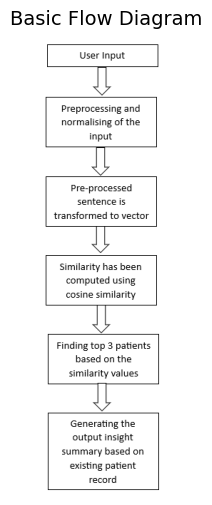

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Load image
img = mpimg.imread(r"C:\Users\rajak\OneDrive\Pictures\Screenshots\Screenshot 2026-02-19 114314.png")
# Display image
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.title("Basic Flow Diagram", fontsize=14)
plt.axis("off")
plt.show()

The systems befins by receiving the user input symptoms and clinical notes. these inputs are then cobined to form a perfect clinical description of the new patient. Then the input is converted into the lowercase, special charachters are removed, unnecessary words are removed and the words are normalised to ensure the consistency of the data. Then the preprocessed cleaned text is converted to semantic embedding. This embedding is numerical vector that captures the contextual meaning of the clinical description. This semantic representation allows the system to understand the entire clinical data. Then the generated embedding is compared with embeddings of existing patient using cosine similarity to find the most similar patients. from the highest similar patients the treatment details and the outcome are referred and suggested to the new patient based on the shared symptoms. Then based on this the output insight summary of the new patient is created.